In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [ ]:
# Load dataset
data = "https://raw.githubusercontent.com/allatifatulmuharomiah/Bot-Twitter-Account-Detection/main/Dataset/twitter_human_bots_dataset.csv"
df = pd.read_csv(data)

In [ ]:
print("Dataset Awal:")
print(df.head())

Dataset Awal:
   Unnamed: 0           created_at  default_profile  default_profile_image  \
0           0  2009-07-04 22:41:51            False                  False   
1           1  2010-01-17 22:54:19            False                  False   
2           2  2012-03-01 06:05:32            False                  False   
3           3  2009-09-01 04:52:30            False                  False   
4           4  2010-01-27 17:17:23            False                  False   

                                         description  favourites_count  \
0                                                NaN              5007   
1  Television producer. Emmy Award winner. Disney...              1038   
2                                                NaN              2257   
3                                                NaN              6407   
4  Productor de Televisión - Embajador de @Tienda...             20866   

   followers_count  friends_count  geo_enabled         id  ...  \
0     

# **Preprocessing**

In [ ]:
# Konversi nilai boolean menjadi bentuk biner
bool_columns = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
for col in bool_columns:
    df[col] = df[col].astype(int)

In [ ]:
# Encode 'account_type': 'bot' menjadi 1 dan 'human' menjadi 0
df['account_type'] = df['account_type'].map({'bot': 1, 'human': 0})

In [ ]:
# Buang kolom yang tidak diperlukan
columns_to_drop = ['Unnamed: 0', 'created_at', 'description', 'profile_background_image_url', 'id', 'profile_image_url', 'screen_name', 'lang']
df = df.drop(columns=columns_to_drop)

In [ ]:
# Tampilkan dataset setelah preprocessing
print("\nDataset setelah Preprocessing:")
print(df.head())


Dataset setelah Preprocessing:
   default_profile  default_profile_image  favourites_count  followers_count  \
0                0                      0              5007              102   
1                0                      0              1038               60   
2                0                      0              2257              599   
3                0                      0              6407              116   
4                0                      0             20866            74448   

   friends_count  geo_enabled         location  statuses_count  verified  \
0            168            0  Maringá, Brasil            3974         0   
1            128            0          Atlanta             259         0   
2            449            1          unknown           13627         0   
3            334            1     Brooklyn, NY            4432         0   
4             18            1        Miami, FL           15870         1   

   average_tweets_per_day  acc

In [ ]:
# Split data menjadi fitur (X) dan target (y)
X = df.drop(columns=['account_type']).select_dtypes(include='number').values.astype('float32')  # Fitur
y = df['account_type'].values.astype('float32')

In [ ]:
# Reshape data input untuk menambah dimensi waktu
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

# Split data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definisi layer input
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))


# **Model**

In [ ]:
# LSTM layers

lstm_out1 = LSTM(200, return_sequences=True)(inputs)
lstm_out2 = LSTM(200, return_sequences=True)(lstm_out1)
lstm_out3 = LSTM(200, return_sequences=True)(lstm_out2)
lstm_out4 = Dropout(0.2)(lstm_out3)
lstm_out5 = LSTM(200, return_sequences=True)(lstm_out4)
lstm_out6 = Dropout(0.2)(lstm_out5)

In [ ]:
# Attention layer

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.squeeze(tf.tanh(tf.matmul(x, self.W) + self.b), axis=-1)
        at = tf.nn.softmax(et)
        at = tf.expand_dims(at, axis=-1)
        output = x * at
        return tf.reduce_sum(output, axis=1)

att_out = AttentionLayer()(lstm_out6)

In [ ]:
# Output layer
output = Dense(1, activation='sigmoid')(att_out)


In [ ]:
# Buat dan compile model dengan optimizer RMSprop
optimizer = RMSprop(learning_rate=0.0001)
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

## **Latih Model**

In [ ]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
749/749 [==============================] - 31s 31ms/step - loss: 0.5732 - accuracy: 0.7139 - val_loss: 0.4652 - val_accuracy: 0.7674
Epoch 2/200
749/749 [==============================] - 21s 28ms/step - loss: 0.4400 - accuracy: 0.7909 - val_loss: 0.4353 - val_accuracy: 0.7955
Epoch 3/200
749/749 [==============================] - 20s 26ms/step - loss: 0.4128 - accuracy: 0.8147 - val_loss: 0.4181 - val_accuracy: 0.8085
Epoch 4/200
749/749 [==============================] - 19s 26ms/step - loss: 0.3997 - accuracy: 0.8227 - val_loss: 0.4064 - val_accuracy: 0.8120
Epoch 5/200
749/749 [==============================] - 21s 27ms/step - loss: 0.3912 - accuracy: 0.8313 - val_loss: 0.3999 - val_accuracy: 0.8230
Epoch 6/200
749/749 [==============================] - 19s 25ms/step - loss: 0.3854 - accuracy: 0.8354 - val_loss: 0.3931 - val_accuracy: 0.8289
Epoch 7/200
749/749 [==============================] - 22s 30ms/step - loss: 0.3811 - accuracy: 0.8399 - val_loss: 0.3932 - val_ac

# **Evaluasi Model**

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

234/234 [==============================] - 2s 9ms/step - loss: 0.3402 - accuracy: 0.8623
Test Loss: 0.3401713967323303
Test Accuracy: 0.8623130321502686


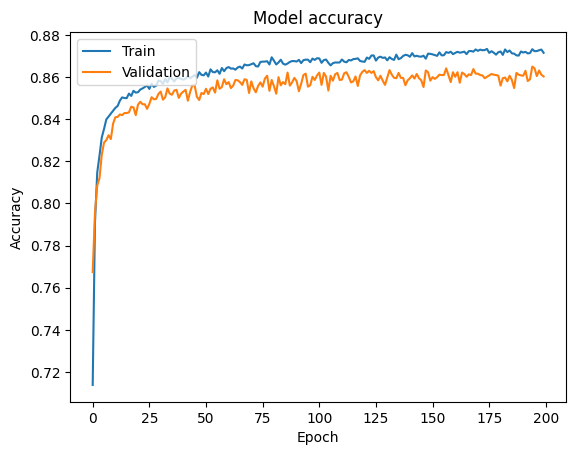

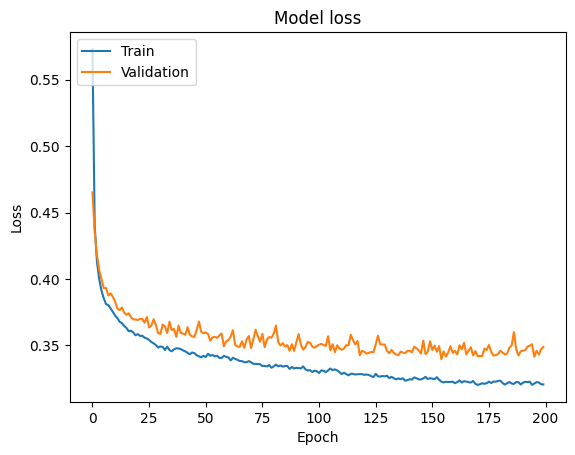

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Prediksi label untuk data pengujian
y_pred = model.predict(X_test)
y_pred_binary = np.round(y_pred)

# Precision
precision = precision_score(y_test, y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred_binary)
print("Recall:", recall)

# F1-score
f1 = f1_score(y_test, y_pred_binary)
print("F1-score:", f1)

# AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)


234/234 [==============================] - 2s 10ms/step - loss: 0.3402 - accuracy: 0.8623
Test Loss: 0.3401713967323303
Test Accuracy: 0.8623130321502686
234/234 [==============================] - 3s 7ms/step
Precision: 0.8479960899315738
Recall: 0.7067209775967414
F1-score: 0.7709397911575205
AUC: 0.9059463346394447


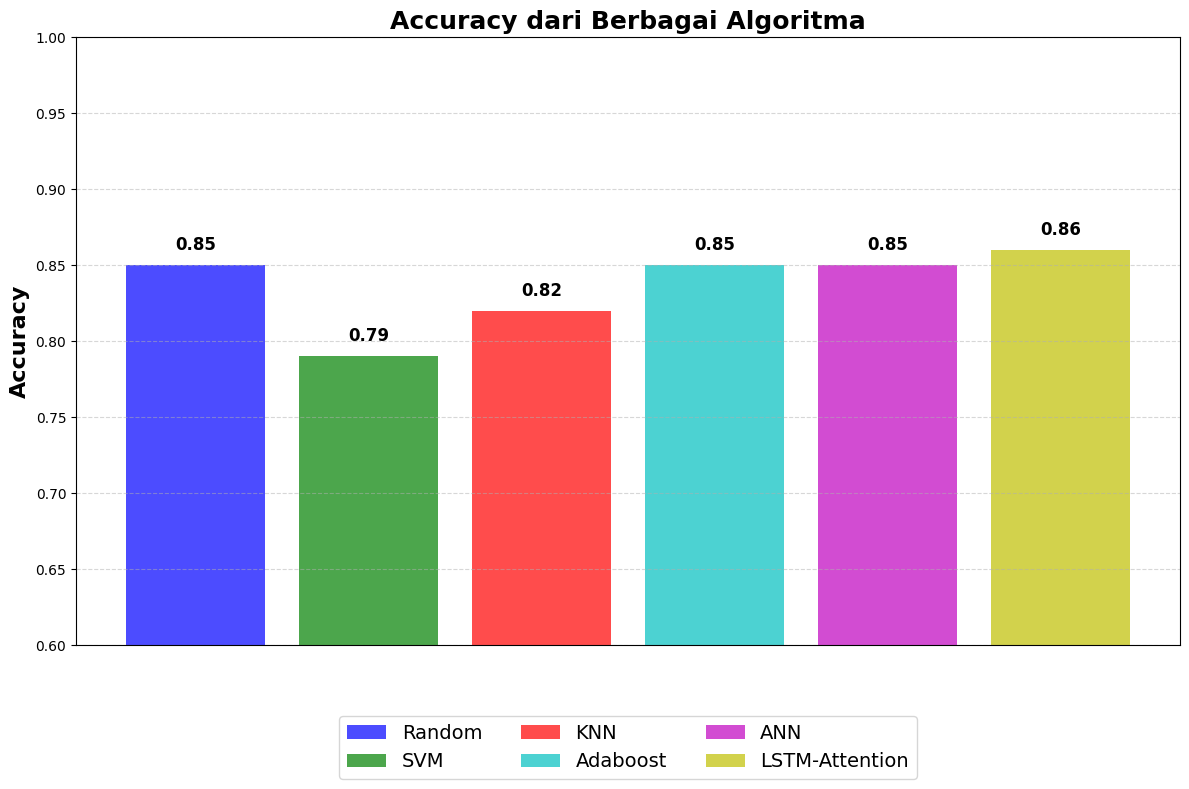

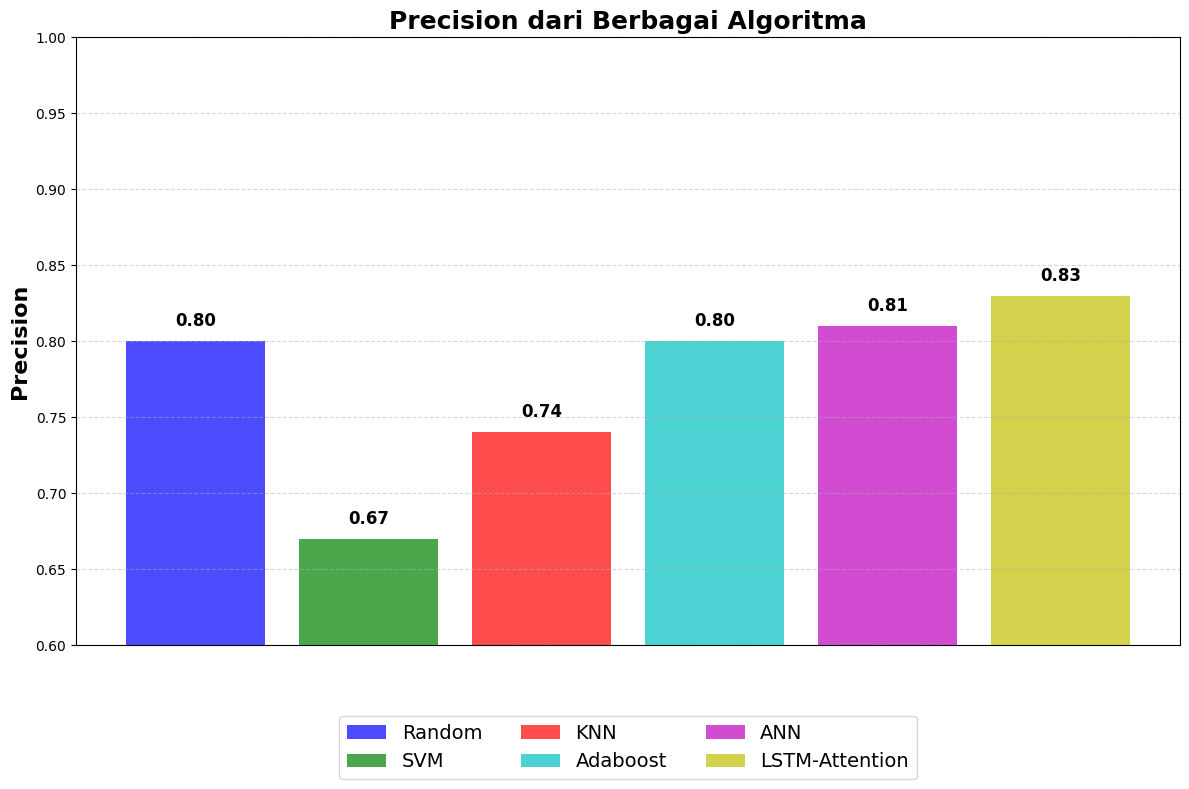

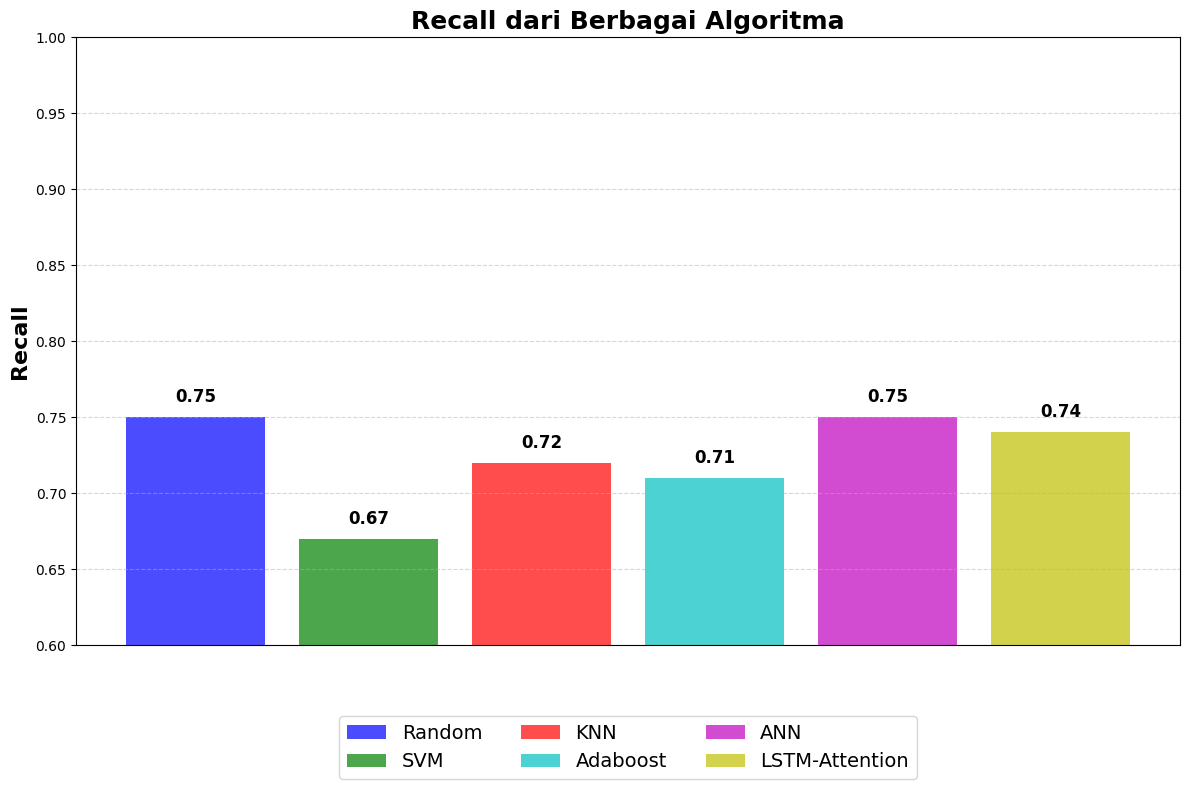

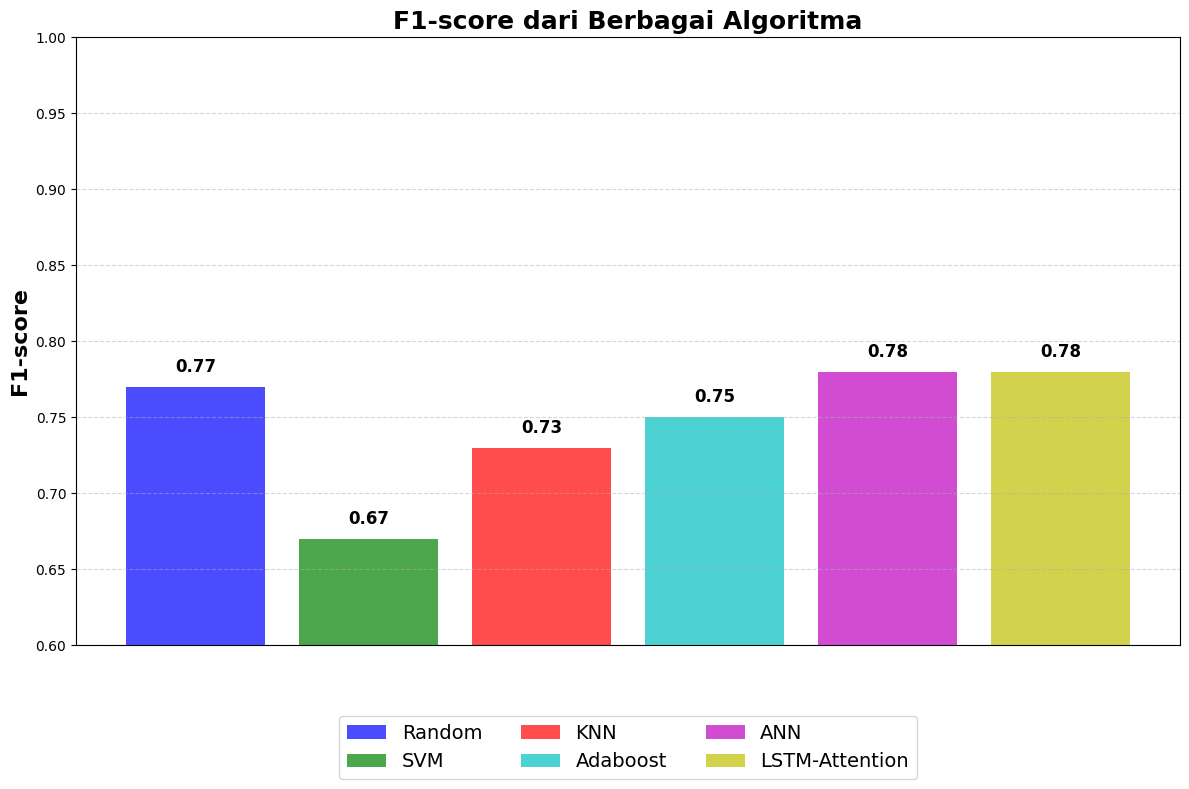

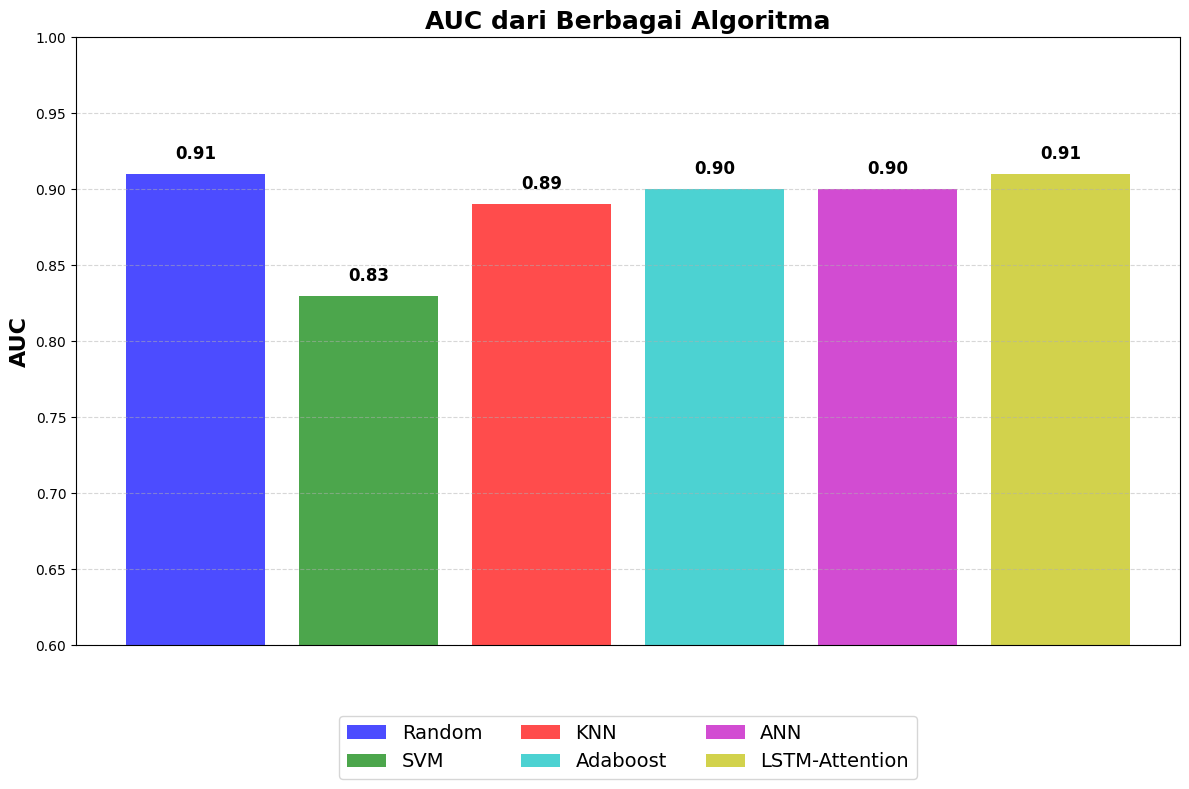

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
algorithms = ['Random Forest', 'SVM', 'KNN', 'Adaboost', 'ANN', 'LSTM-Attention']
accuracy = [0.85, 0.79, 0.82, 0.85, 0.85, 0.86]
precision = [0.80, 0.67, 0.74, 0.80, 0.81, 0.83]
recall = [0.75, 0.67, 0.72, 0.71, 0.75, 0.74]
f1_score = [0.77, 0.67, 0.73, 0.75, 0.78, 0.78]
auc = [0.91, 0.83, 0.89, 0.90, 0.90, 0.91]

# Warna untuk tiap algoritma
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Fungsi untuk membuat grafik batang dengan dua digit desimal pada label
def plot_bar(data, title, ylabel, color, ylim):
    fig, ax = plt.subplots(figsize=(12, 8))
    bar_positions = np.arange(len(algorithms))
    bars = ax.bar(bar_positions, data, align='center', alpha=0.7, color=color)

    # Menambahkan nilai pada setiap batang
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 8),  # 8 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    ax.set_xticks([])  # Menghapus label sumbu x
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=16, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_ylim(ylim)  # Set y-axis limit

    # Menambahkan legenda di bawah grafik
    plt.legend(bars, [algo.split()[0] for algo in algorithms], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(algorithms)//2, fontsize=14, fancybox=True)

    plt.tight_layout()
    plt.show()

# Membuat grafik batang untuk masing-masing metrik dengan y-axis limit dari 0.6 sampai 1.0
plot_bar(accuracy, 'Accuracy dari Berbagai Algoritma', 'Accuracy', colors, (0.6, 1.0))
plot_bar(precision, 'Precision dari Berbagai Algoritma', 'Precision', colors, (0.6, 1.0))
plot_bar(recall, 'Recall dari Berbagai Algoritma', 'Recall', colors, (0.6, 1.0))
plot_bar(f1_score, 'F1-score dari Berbagai Algoritma', 'F1-score', colors, (0.6, 1.0))
plot_bar(auc, 'AUC dari Berbagai Algoritma', 'AUC', colors, (0.6, 1.0))


